Define priors, proprosal distribution, simulated dataset, euclidean distance


In [25]:
import multiprocessing

In [12]:
import random
random.seed(42)
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def model(variables, t, params):
    m, p = variables.reshape((3, 2)).T
    a, n, b, g =params #k set to 0

    dm1dt = -m[0] + (10 ** a / (1 + (10 ** 0 * p[1])**n)) + 10**g  
    dp1dt = -10 ** b * (p[0] - m[0])

    dm2dt = -m[1] + (10 ** a / ((1 + 10 ** 0 * p[2])**n)) + 10**g  
    dp2dt = -10 ** b * (p[1] - m[1])

    dm3dt = -m[2] + (10 ** a / (1 + 10 ** 0 * p[0])**n) + 10**g
    dp3dt = -10 ** b * (p[2] - m[2])

    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]).flatten()

true_params = np.array([
   3.,2.,0.,0.
])


def solve_ode(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
    return solution



In [13]:
true_data = solve_ode(true_params)
def get_distance(truth, simulation):
    mean_squared_difference = np.mean(np.square(truth - simulation))
    return mean_squared_difference #OG distance function, bcz doing ratios same as sum of squared dist

In [5]:
from scipy.stats import norm
from math import prod
from scipy.stats import uniform

In [4]:
def gaussian_kernel(sd):
    gk=np.random.normal(0,sd,size=len(true_params)) #using symmetrical kernels for now
    return(gk) #need to take care in future in not generating negative values! (maybe a distribution that can only have pos values, look at lucias code ig)

In [15]:
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance

In [253]:
def mcmc_abc(true_params, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr=np.zeros(num_iterations+1)
    #accepted_data = np.zeros((num_iterations + 1, len(true_data)))
    count = 0
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=3) #from -3 to 3
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)
    distance= euclidean_distance_multiple_trajectories(true_data, sampled_data)
    for i in range(1, num_iterations + 1):
        if i % 1000 == 0:
            print(f"{i}th iterations done")
        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(0.5) #maybe this is giving parameters that are out of bounds?
        new_sampled_params = sampled_params+perturbation #clipping to ensure stays within bounds
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            pass #do not accept parameters if out of bounds of prior
        # Generate synthetic data using samples
        else:
            new_sampled_data = solve_ode(new_sampled_params)
            new_distance =  euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
            prob = min(1, distance/new_distance) 
            #if new distance is smaller than old, defo accept, 
            #else prob proportional to old_distance/new_distance
            distance_arr[i]=new_distance
            if prob > np.random.uniform(0, 1):
                count += 1
                #accepted_data[i] = sampled_data
                #prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
                sampled_params = new_sampled_params
                distance=new_distance
            accepted_params[i] = sampled_params
        

    return accepted_params, count, distance_arr

In [63]:

def run_mult_chain(algorithm, chain,true_params, num_iterations):
    #algorithm=mcmc_abc or mcmc_abc_s1 scheme1

    chain_accepted_parameters=[]
    counts=[]
    dists=[]
    for i in range(chain):
        accepted_parameters, count, dist = algorithm(true_params, num_iterations)
        chain_accepted_parameters.append(accepted_parameters)
        counts.append(count)
        dists.append(dist)
        print(f"{i+1}th chain done")
    return(chain_accepted_parameters, counts, dists)



def run_mult_chain_parallel(algorithm, chain, true_params, num_iterations):
    pool = multiprocessing.Pool()
    results = [pool.apply_async(algorithm, (true_params, num_iterations)) for _ in range(chain)]
    pool.close()
    pool.join()
    chain_accepted_parameters = [result.get()[0] for result in results]
    counts = [result.get()[1] for result in results]
    dists = [result.get()[2] for result in results]
    return chain_accepted_parameters, counts, dists

Potentialo method for decreasing the threshold: set first and final, every threshold decrease is 1/2 between previous and final

In [7]:
def mcmc_abc_s1(true_params, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr=np.zeros(num_iterations+1)
    count_arr = []
    count=0
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=3) #from -3 to 3
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)
    threshold=300 #initial threshold
    target_thres=15
    distance=euclidean_distance_multiple_trajectories(true_data, sampled_data)
    for i in range(1, num_iterations + 1):
        if i % 2000 == 0:
            count_arr.append(count)
            count=0 #reset count
            if i+2000==num_iterations:
                threshold=target_thres #for final iteration use target threshold
            else:
                threshold=(threshold+target_thres)*0.5
            #decreasingf threshold every 1000 iterations
            #arbitrary at the moment
            #only look at the last 1000 samples for now
            print(f"{i}th iterations done, changing threshold to {threshold}")
        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(0.8) #maybe this is giving parameters that are out of bounds?
        new_sampled_params=sampled_params+perturbation
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            while max(new_sampled_params)>3 or min(new_sampled_params)<-3:
                perturbation = gaussian_kernel(0.8) #perturb again
                new_sampled_params=sampled_params+perturbation 
    # Generate synthetic data using samples
        new_sampled_data = solve_ode(new_sampled_params)
        distance = euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
        if distance < threshold: #if accepted next distance has to be 0.9 of that
            #prob = min(1, distance/new_distance)
            #if prob > np.random.uniform(0, 1):
            count += 1
            #accepted_data[i] = sampled_data
            #prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
            sampled_params = new_sampled_params
        accepted_params[i] = sampled_params 
        distance_arr[i]=distance
                
        
        

    return accepted_params, count_arr, distance_arr

In [17]:
rng = np.random.default_rng()
def multivariate_gaussian_kernel(cov_params,scale=1):
    gk=scale*rng.multivariate_normal(mean=np.zeros(len(true_params)),cov=cov_params) #using symmetrical kernels for now
    return(gk)
 #need to take care in future in not generating negative values! (maybe a distribution that can only have pos values, look at lucias code ig)

Question: should i adapt the kernel size say every 1000 rounds? Or should it be some sort of trigger?
Adaptive kernel size - a lot of literature on this, easiest one just seems to be double the kernel if acceptance is above some arbitrary threshold, half if acceptance rate is below half of that threshold?


In [52]:
def mcmc_abc_s2(true_params, num_iterations):
    true_data = solve_ode(true_params)
    init_cov=2*np.identity(len(true_params))
    #threshold_arr=[80,60,40,20]
    accepted_params = np.zeros((num_iterations, len(true_params)))
    distance_arr= np.zeros(num_iterations+1)
    count_arr = []
    count=0
    cov=init_cov
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=4) #from -3 to 3, six params
     #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)
    threshold=90 #initial threshold
    distance=euclidean_distance_multiple_trajectories(true_data, sampled_data)
    set_distance = distance
    #round=-1
    for i in range(1, num_iterations):
        if i % 10000 == 0:
            #round+=1
            #threshold=threshold_arr[round]
            count_arr.append(count)
            count=0 #reset count
            dis_seg=distance_arr[i-10000:i]
            threshold=np.median(np.unique(dis_seg)) #new threshold median of previous round
            cov=np.cov(accepted_params[:i,:],rowvar=False) #get covariance matrix of accepted parameters, after 1000 burnins
            print(cov)
            #decreasingf threshold every 1000 iterations
            #arbitrary at the moment
            #only look at the last 1000 samples for now
            print(f"{i}th iterations done, changing threshold to {threshold}")
        # Using Gaussian kernel to sample for next model parameters
        perturbation=multivariate_gaussian_kernel(cov)
        new_sampled_params=sampled_params+perturbation
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            while max(new_sampled_params)>3 or min(new_sampled_params)<-3:
                perturbation = multivariate_gaussian_kernel(cov) #perturb again
                new_sampled_params=sampled_params+perturbation 
    # Generate synthetic data using samples
        new_sampled_data = solve_ode(new_sampled_params)
        distance = euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
        if distance < threshold:
            count += 1
            #accepted_data[i] = sampled_data
            #prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
            sampled_params = new_sampled_params 
            set_distance = distance
        distance_arr[i]=set_distance
        accepted_params[i] = sampled_params

    return accepted_params, count_arr, distance_arr

In [54]:
print(count1[0])

[25, 147, 155, 120]


Text(0.5, 1.0, 'Distances with adaptive threshold sizes')

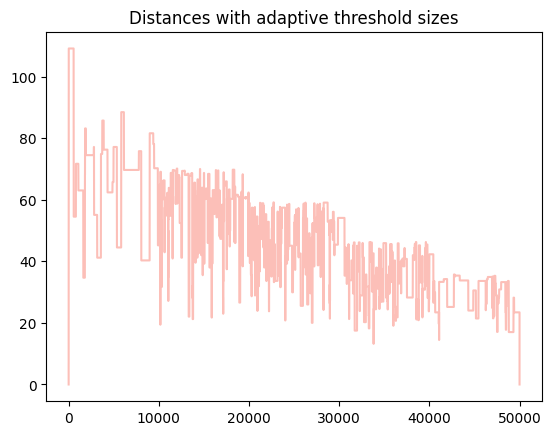

In [56]:
col=["salmon","violet","brown"]
for i in range(len(dist)):
    plt.plot(dist[i],color=col[i],alpha=0.5)
plt.title("Distances with adaptive threshold sizes")

# Parallelized version


In [121]:
from run_mcmc import run_chain
def run_parallel_chains(true_params, num_iterations, num_chains):
    pool = multiprocessing.Pool(processes=num_chains)
    args_list = [(true_params, num_iterations, i) for i in range(num_chains)]
    results = pool.map(run_chain, args_list)
    pool.close()
    pool.join()
    chain_accepted_parameters = [result[0] for result in results]
    counts = [result[1] for result in results]
    dists = [result[2] for result in results]
    return chain_accepted_parameters, counts, dists

In [122]:
ap,c,d=run_parallel_chains(true_params,100000,4)


/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[[ 1.46610513  0.48233447  0.16565932 -0.19324535]
 [ 0.48233447  0.80610686  0.0757789   0.02838014]
 [ 0.16565932  0.0757789   0.65632731 -0.05528304]
 [-0.19324535  0.02838014 -0.05528304  0.21428511]]
80000th iterations done, changing threshold to 92.21788582232175
[[ 1.36353445  0.39356911  0.1649411  -0.15933348]
 [ 0.39356911  0.69141091  0.03862756  0.02290068]
 [ 0.1649411   0.03862756  0.58802394 -0.02304314]
 [-0.15933348  0.02290068 -0.02304314  0.15046335]]
90000th iterations done, changing threshold to 92.1922503090795
[[ 1.58085881  0.5536885   0.04061269 -0.21182351]
 [ 0.5536885   0.72602615  0.04621457  0.04133213]
 [ 0.04061269  0.04621457  0.59545844 -0.02456841]
 [-0.21182351  0.04133213 -0.02456841  0.24740199]]
80000th iterations done, changing threshold to 92.1971269940615
[[ 1.51771633  0.37734183  0.08598415 -0.25576598]
 [ 0.37734183  0.65237388  0.00601708  0.0268332 ]
 [ 0.08598415  0.00601708  0.7227283  -0.03126535]
 [-0.25576598  0.0268332  -0.03126535  

KeyboardInterrupt: 

[[ 8.72770660e-20 -1.87970270e-20  8.42910981e-21 -2.77780392e-20]
 [-1.87970270e-20  4.04836573e-21 -1.81541475e-21  5.98259970e-21]
 [ 8.42910981e-21 -1.81541475e-21  8.14104812e-22 -2.68275456e-21]
 [-2.77780392e-20  5.98259970e-21 -2.68275456e-21  8.84103941e-21]]
40000th iterations done, changing threshold to 109.05435662824982
[[ 2.84245524e-21 -2.32050508e-22 -3.97348399e-21  1.96656242e-21]
 [-2.32050508e-22  1.89440377e-23  3.24384360e-22 -1.60543741e-22]
 [-3.97348399e-21  3.24384360e-22  5.55455814e-21 -2.74907758e-21]
 [ 1.96656242e-21 -1.60543741e-22 -2.74907758e-21  1.36060379e-21]]
40000th iterations done, changing threshold to 121.59303932894375
[[ 5.94038289e-17  7.67693224e-17  7.68064437e-19 -5.37288802e-17]
 [ 7.67693224e-17  9.92112671e-17  9.92592435e-19 -6.94354216e-17]
 [ 7.68064437e-19  9.92592435e-19  9.93072465e-21 -6.94689985e-19]
 [-5.37288802e-17 -6.94354216e-17 -6.94689985e-19  4.85960711e-17]]
50000th iterations done, changing threshold to 229.5156626101

In [115]:
print(c)

[[823, 439, 216, 122, 79, 42, 26, 11, 8], [839, 438, 200, 94, 67, 44, 13, 13, 6], [863, 410, 256, 127, 83, 36, 36, 7, 5], [854, 400, 240, 139, 95, 47, 35, 16, 7]]


In [64]:
pa1,count1, dist=run_mult_chain_parallel(mcmc_abc_s2,2,true_params,10000)

Process SpawnPoolWorker-25:
Process SpawnPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'mcmc_abc_s2' on <module '__main__' (built-in)>
  File "/Users/E_V_/Documents/Uni/PostGrad/Project_1/.conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
 

KeyboardInterrupt: 

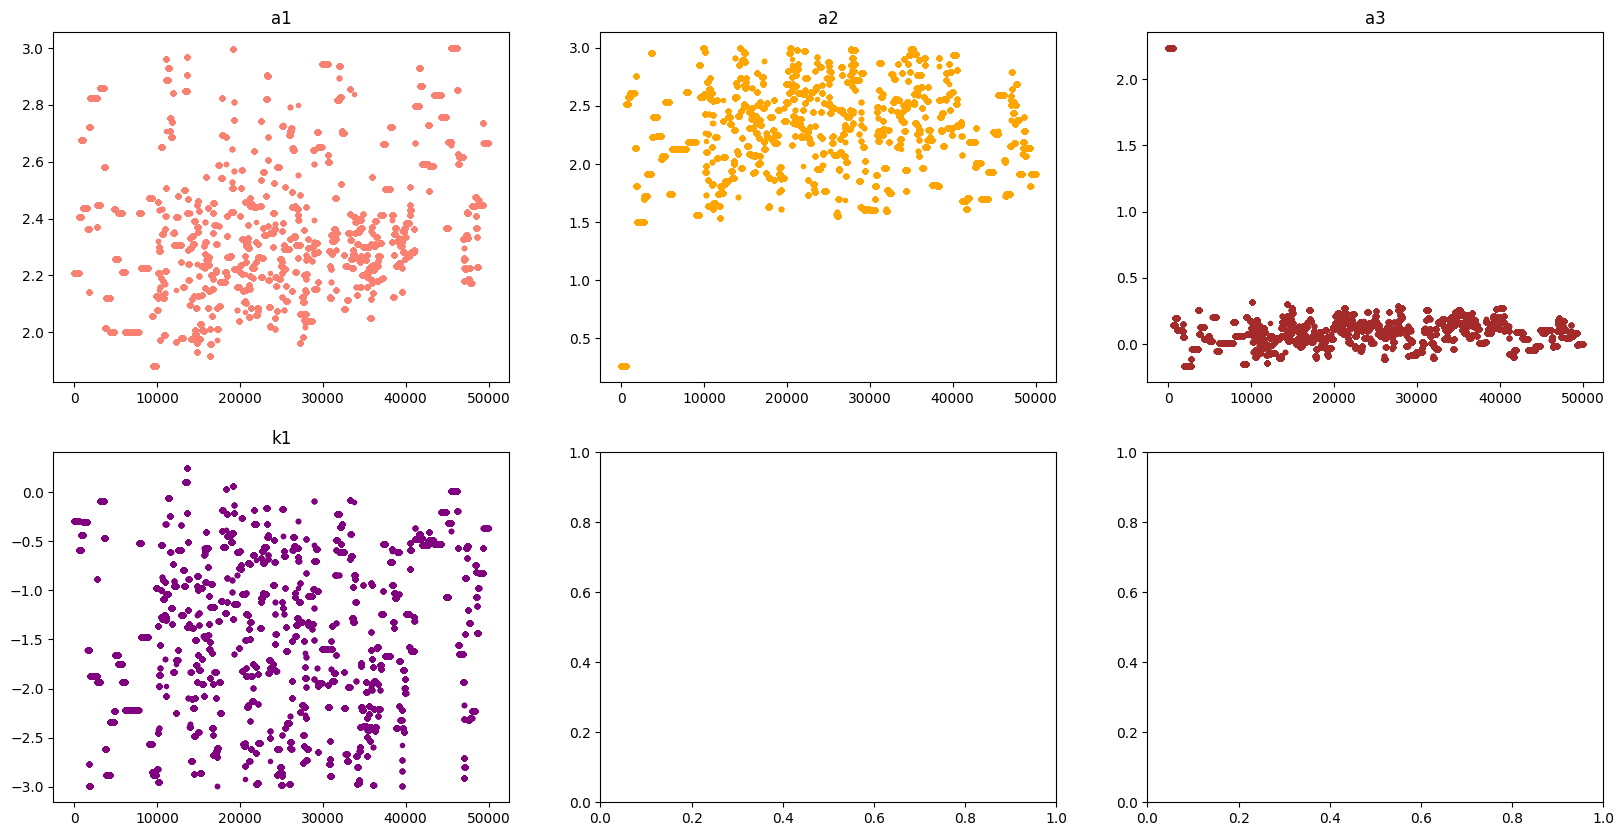

In [57]:
fig, axs = plt.subplots(2,3,figsize=(20, 10))
col=["salmon","orange","brown","purple","violet","skyblue"]
labels=["a1","a2","a3","k1","k2","k3"]
axs = axs.ravel()
for i in range(len(true_params)):
   for j in range(len(pa1)):
      array=pa1[j][:,i] #jth chain
      axs[i].plot(array,marker='.',linestyle='',color=col[i]) #each param, plot the results from chain
      axs[i].set_title(labels[i])



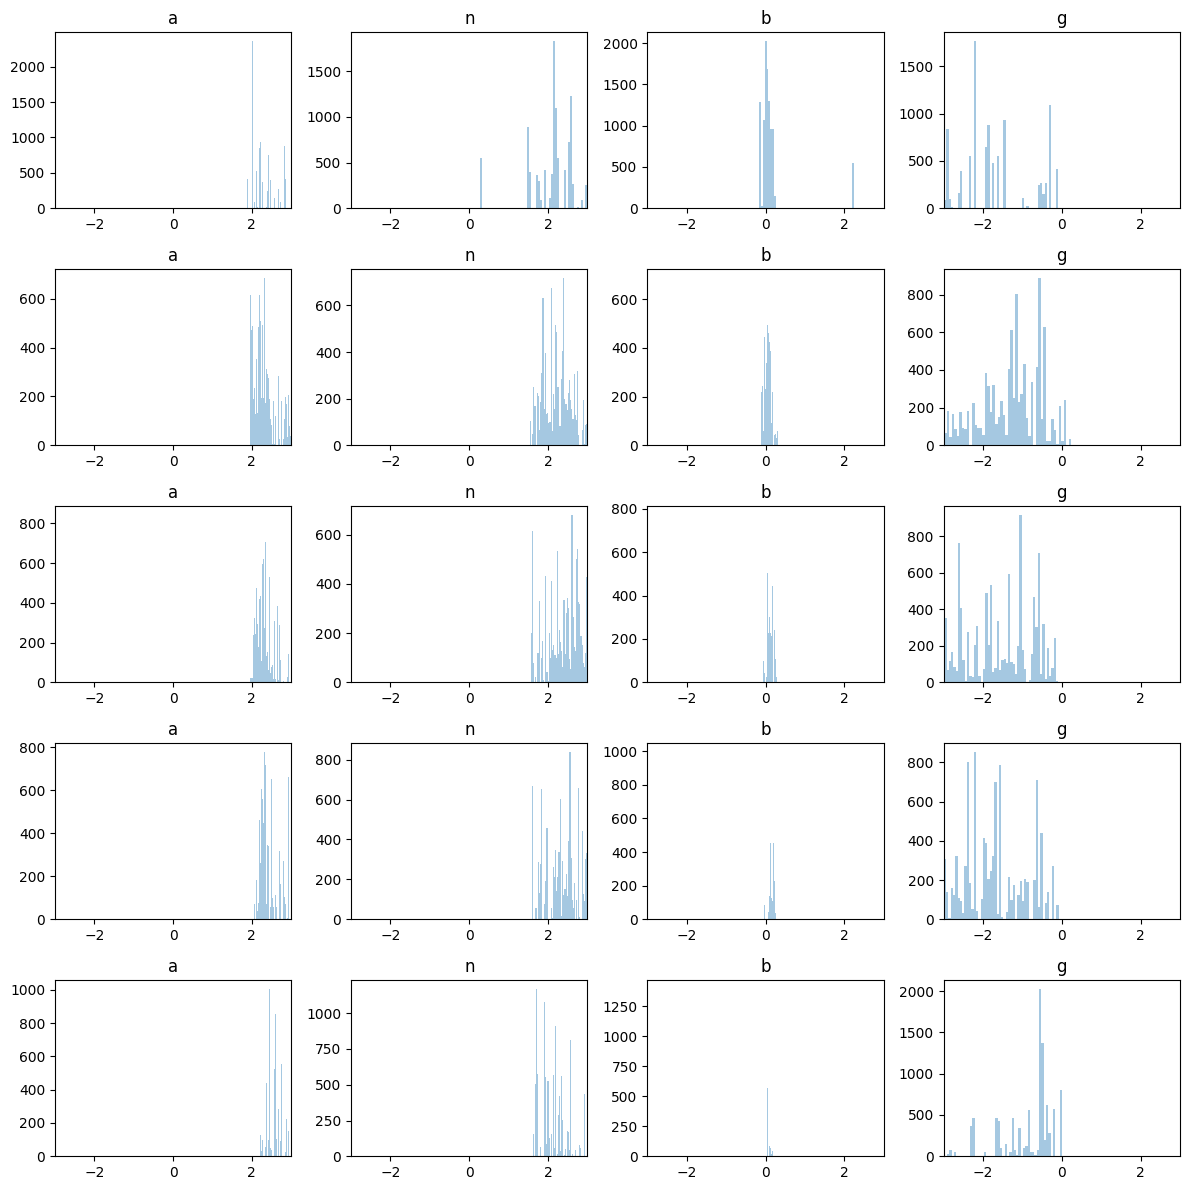

In [62]:
labels=["a","n","b","g"]
fig, axs = plt.subplots(5,4,figsize=(12, 12))

for n in range(5):
    for p in range(0,4):
        axs[n,p].hist(pa1[0][:,p][10000*(n):10000*(n+1)-1], alpha=.4, bins=50)
        axs[n,p].set_title(labels[p])
        axs[n,p].set_xlim(-3,3)
fig.tight_layout()

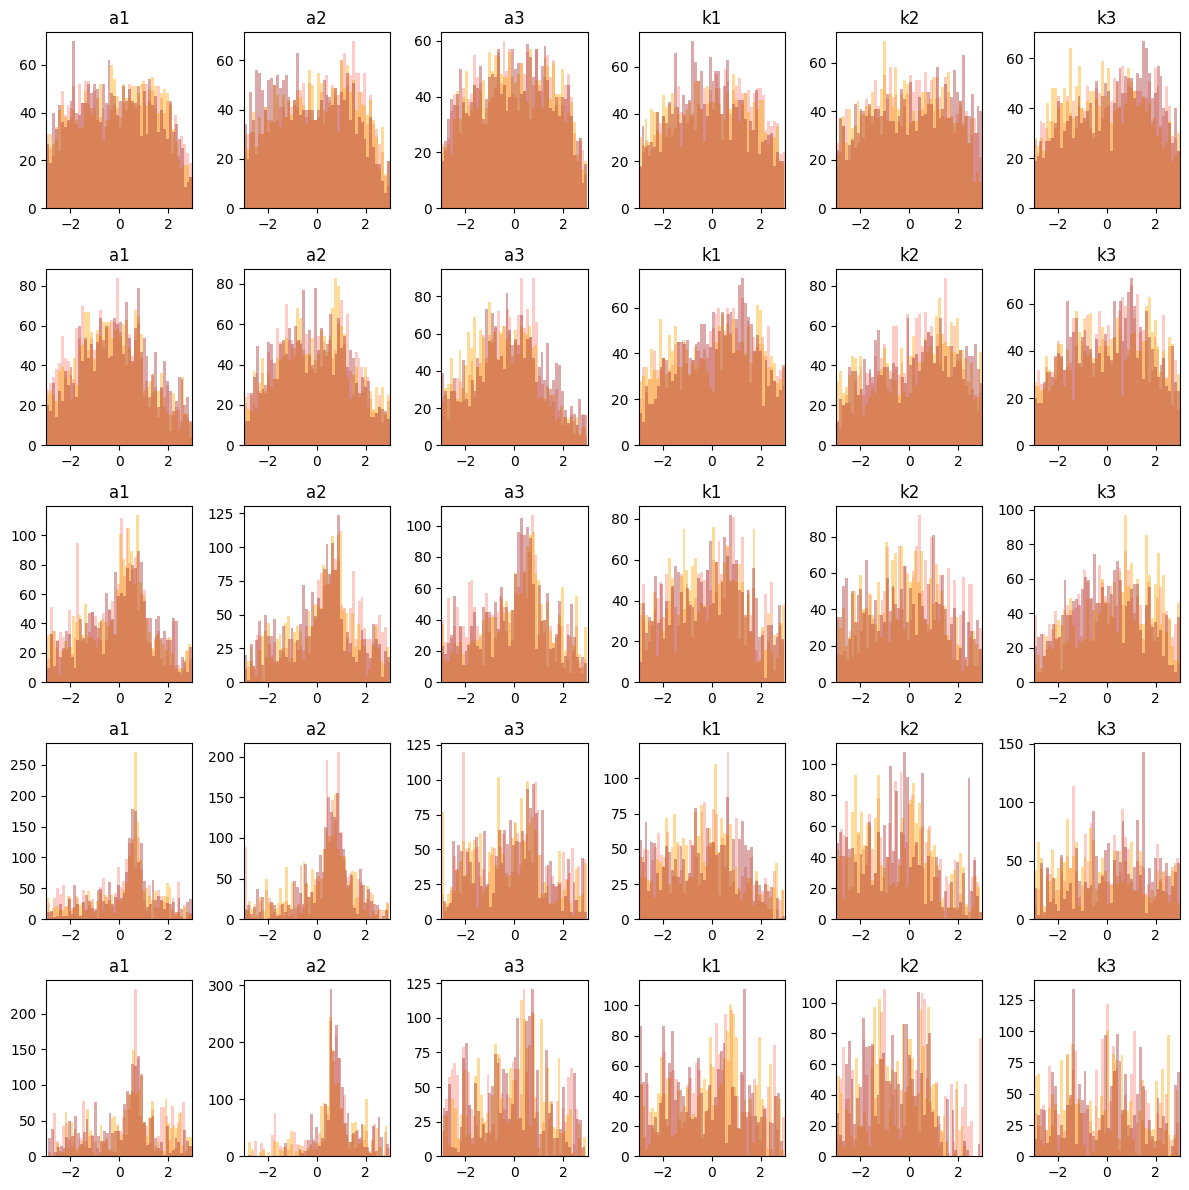

In [73]:
labels=["a1","a2","a3","k1","k2","k3"]
fig, axs = plt.subplots(5,6,figsize=(12, 12))

for n in range(5):
    for p in range(0,6):
        for i in range(0,3):
            axs[n,p].hist(pa1[i][:,p][2000*(n):2000*(n+1)], alpha=.4, bins=50,color=col[i])

        axs[n,p].set_title(labels[p])
        axs[n,p].set_xlim(-3,3)
fig.tight_layout()

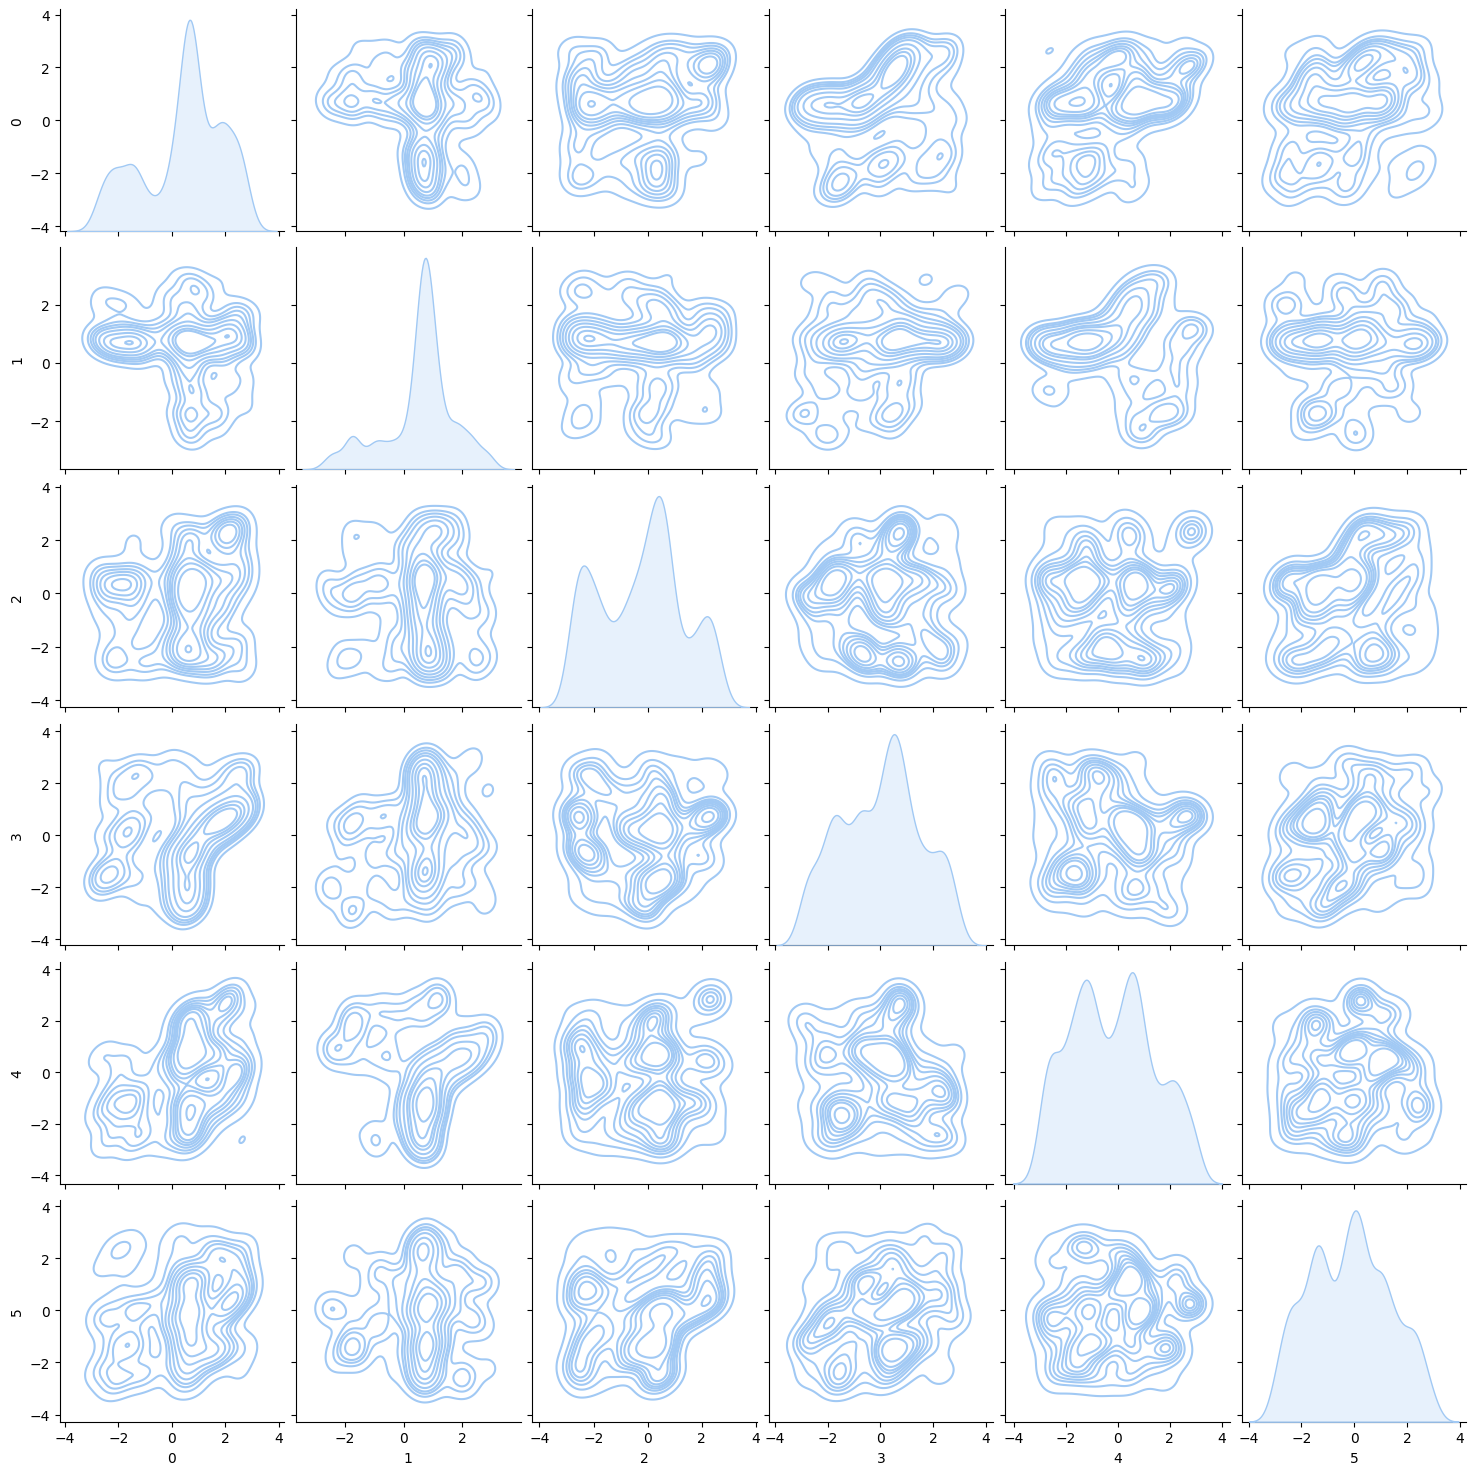

In [74]:
import pandas as pd
import seaborn as sns
plot_k = pd.DataFrame(data=np.array(pa1[0][-2000:,:])) #Just create a dataframe with rows corresponding to params
g=sns.PairGrid(plot_k, diag_sharey=False)
sns.pairplot(plot_k, kind="kde") #Just plot using a smoothing command (edited) 
g.map_lower(sns.scatterplot,hue=distances,legend="full")
g.map_upper(sns.kdeplot, cmap="Reds")

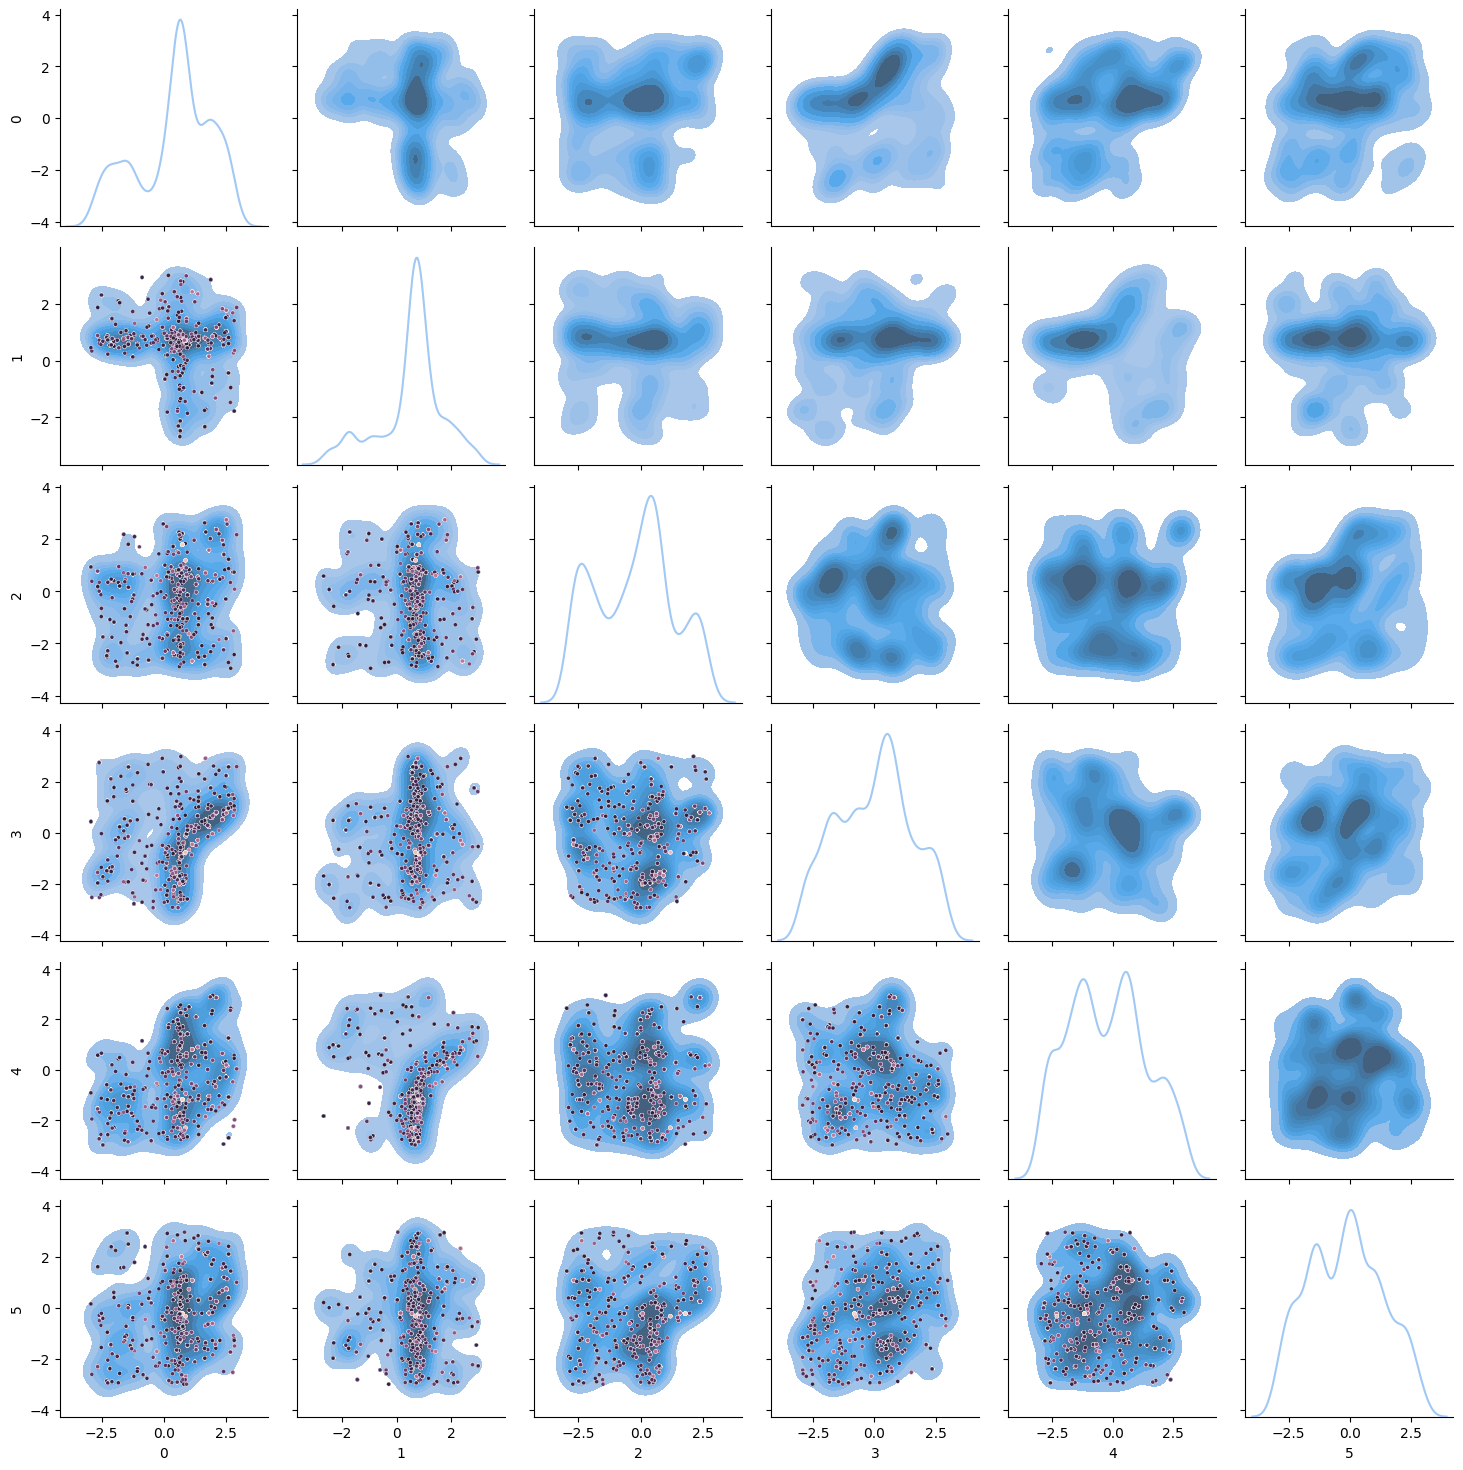

In [178]:
distances= dist[0][-2000:] 
g= sns.PairGrid(plot_k, diag_sharey=False)
g.map_offdiag(sns.kdeplot,fill=True, hue=None)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot,hue=distances,legend="full",s=8)
#g.add_legend()

186


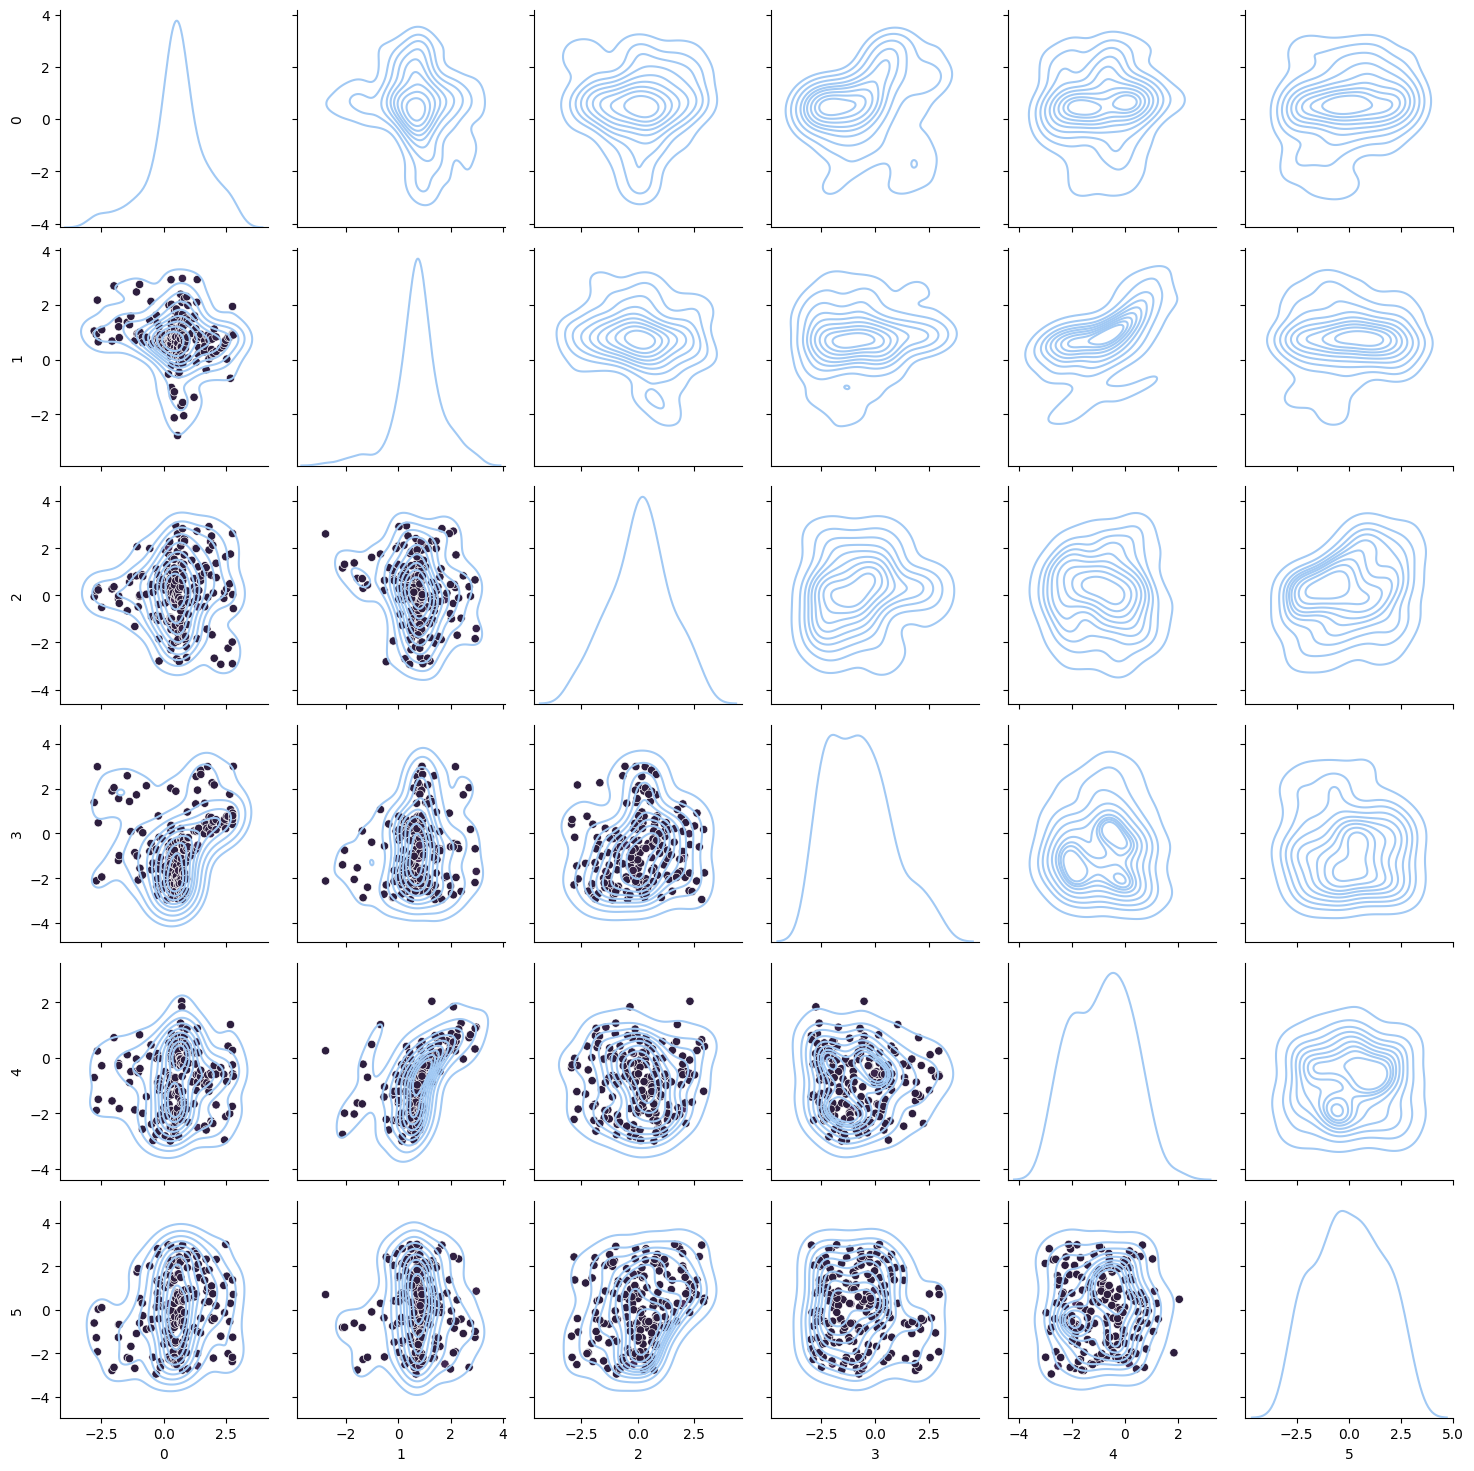

In [135]:
#trajectories quantile
raw_trajectories=np.zeros([2000,100,6])
results=pa1[0][-2000:,]
print(results)
for i in range(results.shape[0]):
    raw_trajectories[i]=solve_ode(results[i,:])

tr=np.percentile(raw_trajectories, [25,50,75], axis=0)
    

[[ 1.65121298  0.79265341  2.61246514  2.11005964 -1.35279175  2.1376597 ]
 [ 1.65121298  0.79265341  2.61246514  2.11005964 -1.35279175  2.1376597 ]
 [ 1.65121298  0.79265341  2.61246514  2.11005964 -1.35279175  2.1376597 ]
 ...
 [ 0.77497643  0.47792818 -0.48758665 -0.40080724 -2.61281258  1.7204416 ]
 [ 0.53560767  0.50073725 -1.31524623  0.1655818  -1.46559612  1.0093999 ]
 [ 0.53560767  0.50073725 -1.31524623  0.1655818  -1.46559612  1.0093999 ]]


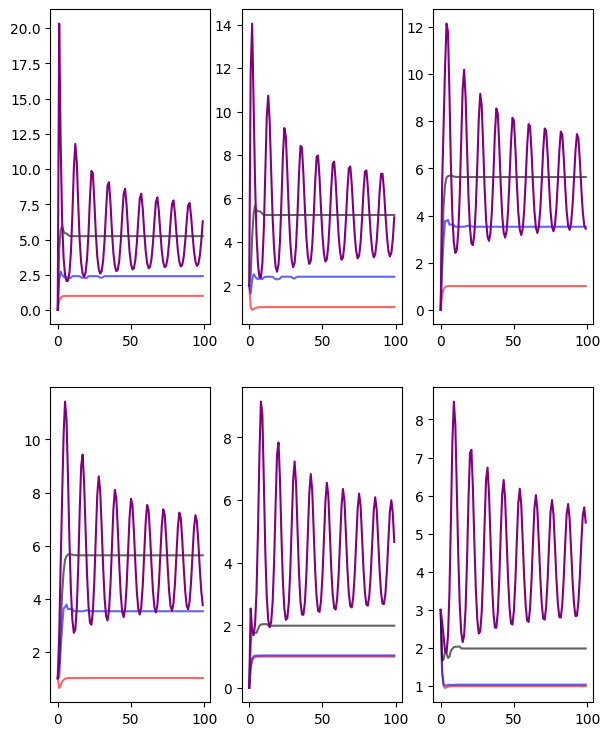

In [152]:
fig, ax=plt.subplots(2,3,figsize=(7,9))
ax = ax.ravel()
col=["red","blue","black"]
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    for j in range(3):
        ax[i].plot(tr[j,:,i],c=col[j],alpha=0.61)
    ax[i].plot(true_data[:,i],c="purple")


    


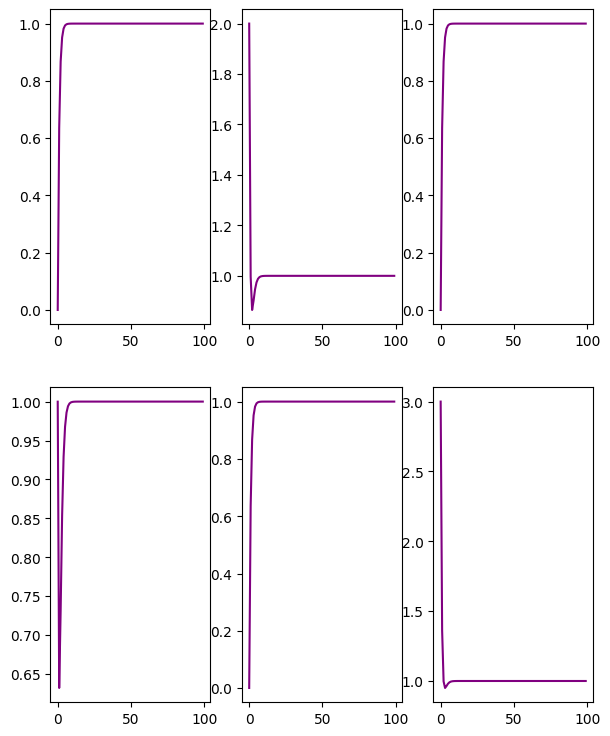

In [173]:
fig, ax=plt.subplots(2,3,figsize=(7,9))
ax = ax.ravel()
true=solve_ode(np.array([-2.,2.,3.,3.,3.,3.]))
for i in range(6):
    ax[i].plot(true[:,i],c="purple")



In [181]:
true_data=solve_ode(np.array([-2.,2.,1.,1.,2.,2.]))
params=np.array(np.array([-2.,2.,1.,1.,2.,2.]))
pa2,count2, dist2=run_mult_chain(mcmc_abc_s2,3,params,10000)

2000th iterations done, changing threshold to 3.674465678674552
[[ 1.700047   -0.05966842  0.12568606  0.67283938 -0.11259463  0.11797606]
 [-0.05966842  1.70347537  0.12127481  0.01102073  0.47707614  0.1811892 ]
 [ 0.12568606  0.12127481  1.78172708 -0.04712562  0.18260677  0.60161545]
 [ 0.67283938  0.01102073 -0.04712562  1.99386791 -0.06143169 -0.2353083 ]
 [-0.11259463  0.47707614  0.18260677 -0.06143169  1.61532228  0.09019722]
 [ 0.11797606  0.1811892   0.60161545 -0.2353083   0.09019722  1.95362092]]
4000th iterations done, changing threshold to 0.30847822688010634
[[ 1.63756708 -0.07356514  0.01675909  0.65939269  0.02753103  0.02515324]
 [-0.07356514  1.60896539  0.14400675 -0.02837598  0.64889704  0.11491884]
 [ 0.01675909  0.14400675  1.74301624 -0.09855576  0.08546266  0.73886669]
 [ 0.65939269 -0.02837598 -0.09855576  1.87332321 -0.03475875 -0.14566904]
 [ 0.02753103  0.64889704  0.08546266 -0.03475875  1.82145495  0.01174544]
 [ 0.02515324  0.11491884  0.73886669 -0.145

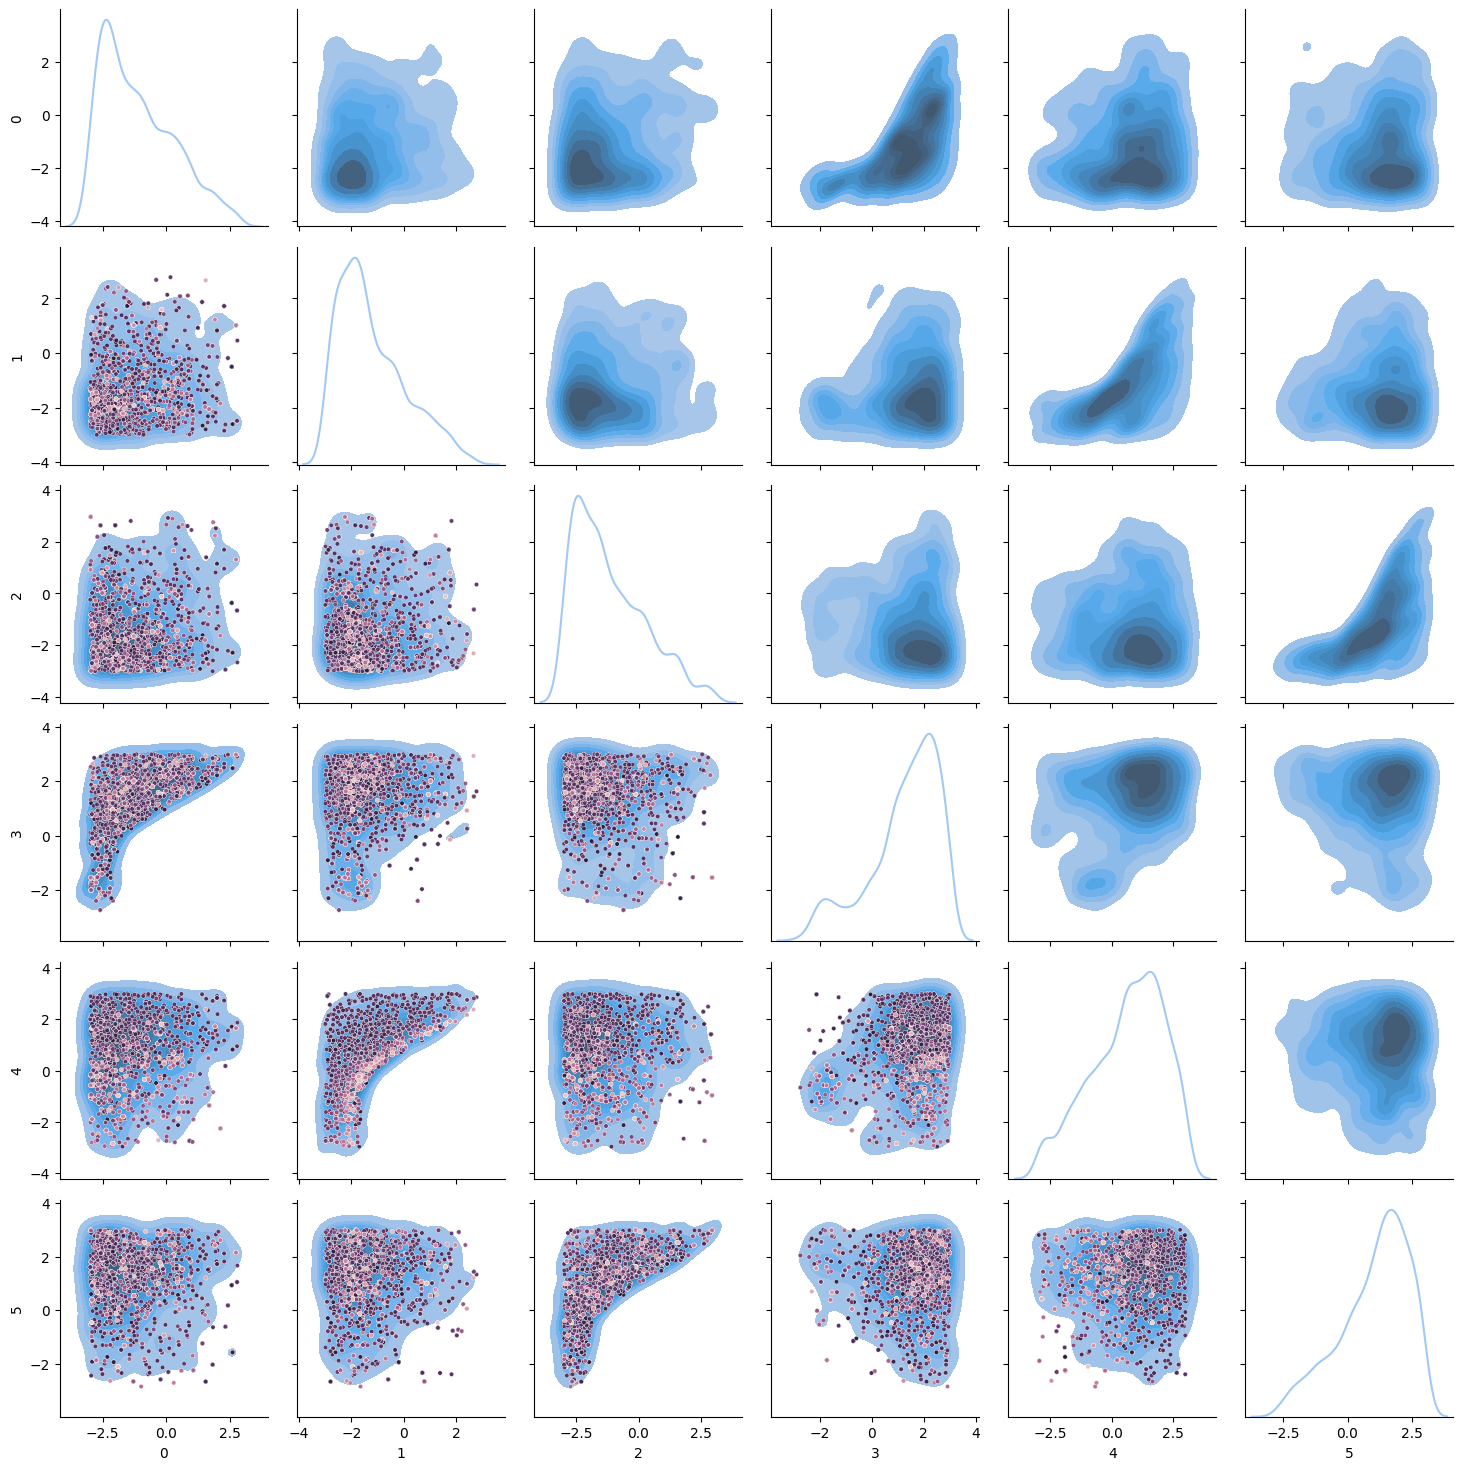

In [183]:
distances= dist2[0][-2000:] 
g= sns.PairGrid(pd.DataFrame(data=np.array(pa2[0][-2000:,:])), diag_sharey=False)
g.map_offdiag(sns.kdeplot,fill=True, hue=None)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot,hue=distances,legend="full",s=10)
#g.add_legend()

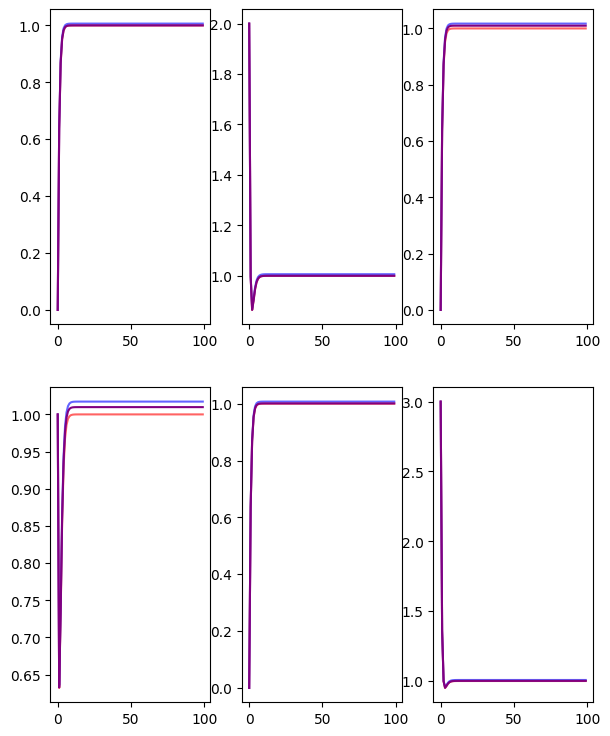

In [190]:

raw_trajectories=np.zeros([2000,100,6])
results=pa2[0][-2000:,]
for i in range(results.shape[0]):
    raw_trajectories[i]=solve_ode(results[i,:])
tr=np.percentile(raw_trajectories, [2.5,97.5], axis=0)
fig, ax=plt.subplots(2,3,figsize=(7,9))
ax = ax.ravel()
col=["red","blue","black"]
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    for j in range(2):
        ax[i].plot(tr[j,:,i],c=col[j],alpha=0.61)
    ax[i].plot(true_data[:,i],c="purple")
    

29.913635327198268


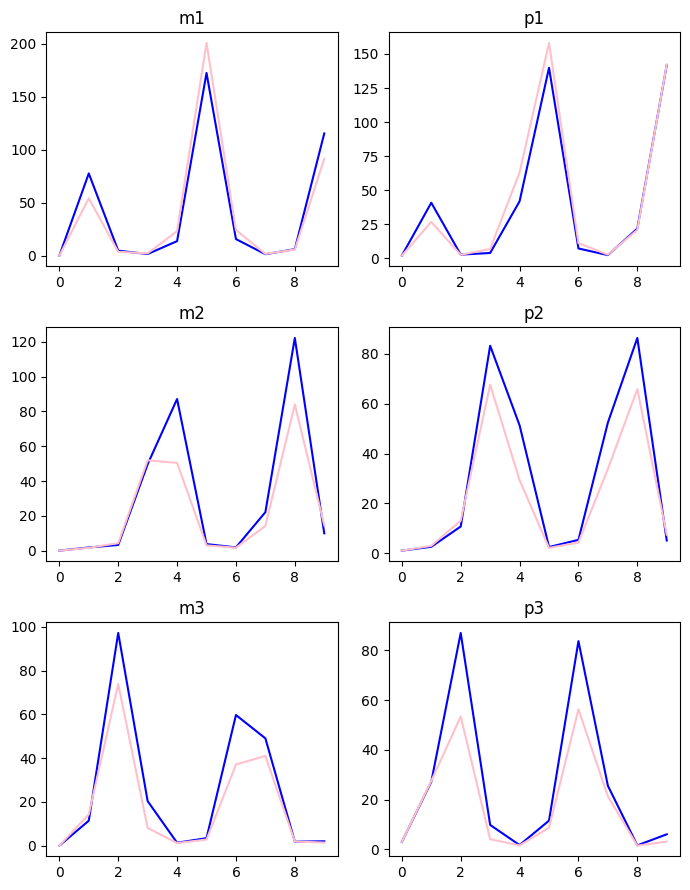

In [423]:
sol2=solve_ode([0,0,0])
sol1=solve_ode([0,0.2,0])
#sol2=solve_ode([2,1,1.5])
#sol4=solve_ode([1.5,2,1])
#sol4=solve_ode([-3,3,])
fig, ax=plt.subplots(3,2,figsize=(7,9))
ax = ax.ravel()
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    #ax[i].plot(sol3[:,i])
    #ax[i].plot(sol1[:,i], c="pink")
    ax[i].plot(sol2[:,i],c="blue")
    ax[i].plot(sol1[:,i],c="pink")
    ax[i].set_title(titles[i])

print(euclidean_distance_multiple_trajectories(sol1,sol2))
fig.tight_layout()

k2=accepted_parameters[:,2]
len(k2)

In [8]:
def mcmc_abc(true_params, epsilon, num_iterations):
    accepted_params = []
    accepted_data = []  # Added to store simulated data for accepted parameters
    count=0 #calculate acceptance rate
    count_lower_thaneps=0
   #initialised to random parameters
    sampled_params = 10**(np.random.uniform(-3,3,size=12))
    accepted_params.append(sampled_params)
    prior_prob=prior_pdf(sampled_params) #for now we only need priors cuz proprosal symetrical
    for i in range(num_iterations):
        if i%10==0:
            print(str(i)+"th iterations done")
        # using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(1)
        new_sampled_params = sampled_params + perturbation #new params = old params +perturbation
        # Generate synthetic data using samples
        sampled_data = solve_ode(new_sampled_params)
        distance = get_distance(true_data, sampled_data)
        if distance < epsilon:
            prior_prob_new=prior_pdf(new_sampled_params)
            prob=min(1, prior_prob_new/prior_prob)
            count_lower_thaneps+=1
            if prob>np.random.uniform(0,1):
                accepted_params.append(sampled_params)
                accepted_data.append(sampled_data)
                count+=1
                prior_prob=prior_prob_new #keep track of prior probs for efficiency
                sampled_params=new_sampled_params #
            
    return np.array(accepted_params), np.array(accepted_data), count, count_lower_thaneps


# ABC rejection
#accepted_parameters, accepted_data = abc_rejection(true_params, epsilon, num_samples, num_timesteps)

In [9]:
accepted_parameters, accepted_data, count, count_lower = mcmc_abc(true_params, epsilon, 100)

What's the point of using mcmc if priors are uniformly distributed? hastings ratio = 1, always accept

In [ ]:
print(count)

In [7]:
def mcmc_abc(true_params, epsilon, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    accepted_data = np.zeros((num_iterations + 1, len(true_data)))
    count = 0
    count_lower_than_eps = 0

    # Initialized to random parameters
    sampled_params = 10 ** (np.random.uniform(-3, 3, size=12))
    accepted_params[0] = sampled_params
    prior_prob = prior_pdf(sampled_params)

    for i in range(1, num_iterations + 1):
        if i % 10 == 0:
            print(f"{i}th iterations done")

        # Using Gaussian kernel to sample for next model parameters
        perturbation = gaussian_kernel(1)
        new_sampled_params = sampled_params + perturbation

        # Generate synthetic data using samples
        sampled_data = solve_ode(new_sampled_params)
        distance = get_distance(true_data, sampled_data)

        if distance < epsilon:
            prior_prob_new = prior_pdf(new_sampled_params)
            prob = min(1, prior_prob_new / prior_prob)
            count_lower_than_eps += 1

            if prob > np.random.uniform(0, 1):
                count += 1
                accepted_params[i] = sampled_params
                accepted_data[i] = sampled_data
                prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
                sampled_params = new_sampled_params

    return accepted_params[:count + 1], accepted_data[:count + 1], count, count_lower_than_eps

In [8]:
accepted_parameters, accepted_data, count, count_lower = mcmc_abc(true_params, epsilon, 100)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1111111111111D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2222222222222D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2222222222222D+00


/Users/E_V_/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/m7/d_1f6t111ksdtr99n9zf9fjh0000gp/T/ipykernel_40151/3313981813.py:6: RuntimeWarning: invalid value encountered in log10
  return uniform.pdf(np.log10(params))


ValueError: could not broadcast input array from shape (10,6) into shape (10,)